# Part 2
# Term Deposit Marketing - ML Project
---


**Part 2 Objective:**

In this second part of the project, we focus on identifying clients who are likely to subscribe to the Term Deposit. The goal is to help the bank understand the key segments within this group, enabling more targeted and effective marketing campaigns based on client profiles.

**Plan of work:**

We will segment the population of subscriber (y=1) using unsupervised learning techniques (specifically, clustering) to identify meaningful client profiles the bank should prioritize.

The clustering will be used as a profiling tool, not a prediction tool. The goal is actionable segmentation, meaning the business can say: “Let’s prioritize Cluster 2: students and retirees contacted in July with high balances”.

For the part 2 I will use `DuckDB` which is an excellent choice when working with tabular data and want fast, in-memory analytics using SQL. Perfect for exploring or preprocessing datasets like ours.

----

### 1. Load the Dataset using DuckDB

In [1]:
import duckdb
import pandas as pd

In [2]:
# Load directly into DuckDB from CSV
con = duckdb.connect()
con.execute("""
    CREATE OR REPLACE TABLE term_deposit AS
    SELECT * FROM read_csv_auto('term-deposit-marketing.csv', header=True)
""")

In [3]:
# Check the first few rows
df_preview = con.execute("SELECT * FROM term_deposit LIMIT 5").df()
print(df_preview)

   age           job  marital  education  default  balance  housing   loan  \
0   58    management  married   tertiary    False     2143     True  False   
1   44    technician   single  secondary    False       29     True  False   
2   33  entrepreneur  married  secondary    False        2     True   True   
3   47   blue-collar  married    unknown    False     1506     True  False   
4   33       unknown   single    unknown    False        1    False  False   

   contact  day month  duration  campaign      y  
0  unknown    5   may       261         1  False  
1  unknown    5   may       151         1  False  
2  unknown    5   may        76         1  False  
3  unknown    5   may        92         1  False  
4  unknown    5   may       198         1  False  


In [4]:
# Duckdb native visualization (no need of pandas)
con.execute("SELECT * FROM term_deposit LIMIT 5").fetchdf()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,False,2143,True,False,unknown,5,may,261,1,False
1,44,technician,single,secondary,False,29,True,False,unknown,5,may,151,1,False
2,33,entrepreneur,married,secondary,False,2,True,True,unknown,5,may,76,1,False
3,47,blue-collar,married,unknown,False,1506,True,False,unknown,5,may,92,1,False
4,33,unknown,single,unknown,False,1,False,False,unknown,5,may,198,1,False


In [5]:
con.execute("PRAGMA table_info('term_deposit')").fetchdf()

,cid,name,type,notnull,dflt_value,pk
0,0,age,BIGINT,False,None,False
1,1,job,VARCHAR,False,None,False
2,2,marital,VARCHAR,False,None,False
3,3,education,VARCHAR,False,None,False
4,4,default,BOOLEAN,False,None,False
5,5,balance,BIGINT,False,None,False
6,6,housing,BOOLEAN,False,None,False
7,7,loan,BOOLEAN,False,None,False
8,8,contact,VARCHAR,False,None,False
9,9,day,BIGINT,False,None,False


In [6]:
con.execute("""
    SELECT 
        COUNT(*) AS count,
        AVG(age) AS mean_age,
        STDDEV(age) AS std_age,
        MIN(age) AS min_age,
        MAX(age) AS max_age,

        AVG(balance) AS mean_balance,
        STDDEV(balance) AS std_balance,
        MIN(balance) AS min_balance,
        MAX(balance) AS max_balance,

        AVG(duration) AS mean_duration,
        STDDEV(duration) AS std_duration,
        MIN(duration) AS min_duration,
        MAX(duration) AS max_duration

    FROM term_deposit;
""").fetchdf()

,count,mean_age,std_age,min_age,max_age,mean_balance,std_balance,min_balance,max_balance,mean_duration,std_duration,min_duration,max_duration
0,40000,40.5446,9.641776,19,95,1274.27755,2903.769716,-8019,102127,254.8243,259.366498,0,4918


### 2. Explore & Clean the Data

In [7]:
con.execute("""
    SELECT
    COUNT(*) AS total_rows,
    COUNT(age) AS non_null_age,
    COUNT(job) AS non_null_job,
    COUNT(balance) AS non_null_balance,
    COUNT(duration) AS non_null_duration
    FROM term_deposit;
""").fetchdf()

,total_rows,non_null_age,non_null_job,non_null_balance,non_null_duration
0,40000,40000,40000,40000,40000


#### 2.1 Select Features for Clustering

Because there are columns related with the call campaign that can add noise to the client's clustering process, we decide clean some columns:

In [8]:
con.execute("""
    CREATE OR REPLACE VIEW term_deposit_clean AS
    SELECT
        age,
        job,
        marital,
        education,
        "default" AS has_default,
        balance,
        housing AS has_housing,
        loan AS has_loan,
        y AS target
    FROM term_deposit
    WHERE target = True;
""")


#### 2.2 Understand Categorical Columns

In [60]:
categoricals = ['job', 'marital', 'education']
for col in categoricals:
    print(f"\nValue counts for '{col}':")
    print(con.execute(f"""
        SELECT {col}, COUNT(*) AS count 
        FROM term_deposit_clean 
        WHERE target = TRUE
        GROUP BY {col} 
        ORDER BY count DESC
""").fetchdf())




Value counts for 'job':
              job  count
0      management    676
1     blue-collar    535
2      technician    497
3           admin    351
4        services    238
5         retired    151
6   self-employed    112
7      unemployed     96
8    entrepreneur     88
9         student     82
10      housemaid     53
11        unknown     17

Value counts for 'marital':
    marital  count
0   married   1478
1    single   1027
2  divorced    391

Value counts for 'education':
   education  count
0  secondary   1418
1   tertiary   1029
2    primary    353
3    unknown     96


#### 3. Encoding and Feature Engineering (SQL)

DuckDB does not support Z_SCORE() as a built-in SQL function. Then, we will perform the calculation in 2-steps.

In [10]:
mean_age, std_age, mean_balance, std_balance = con.execute("""
    SELECT
       AVG(age) AS mean_age,
       STDDEV_SAMP(age) AS std_age,
       AVG(LOG(ABS(balance) + 1)) AS mean_balance,
       STDDEV_SAMP(LOG(ABS(balance) + 1)) AS std_balance
    FROM term_deposit_clean
""").fetchone()


In [11]:
print(f"{mean_age = }\n{std_age = }\n{mean_balance = }\n{std_balance = }")

mean_age = 39.84495856353591
std_age = 11.001984220396205
mean_balance = 2.630741327314328
std_balance = 0.9629544120894596


In [12]:
con.execute(f"""
CREATE OR REPLACE VIEW term_deposit_encoded AS
SELECT
    -- Standardize age manually
    (age - {mean_age}) / {std_age} AS age_t,

    -- Log-transform + standardize balance
    SIGN(balance) AS balance_sign,
    (LOG(ABS(balance) + 1) - {mean_balance}) / {std_balance} AS balance_t,

    -- One-hot encode job
    (job = 'admin.')::INT AS job_admin,
    (job = 'blue-collar')::INT AS job_bluecollar,
    (job = 'technician')::INT AS job_technician,
    (job = 'services')::INT AS job_services,
    (job = 'management')::INT AS job_management,
    (job = 'retired')::INT AS job_retired,
    (job = 'self-employed')::INT AS job_selfemployed,
    (job = 'entrepreneur')::INT AS job_entrepreneur,
    (job = 'unemployed')::INT AS job_unemployed,
    (job = 'housemaid')::INT AS job_housemaid,
    (job = 'student')::INT AS job_student,
    (job = 'unknown')::INT AS job_unknown,

    -- One-hot encode marital
    (marital = 'married')::INT AS marital_married,
    (marital = 'single')::INT AS marital_single,
    (marital = 'divorced')::INT AS marital_divorced,
    (marital = 'unknown')::INT AS marital_unknown,

    -- Ordinal encode education
    CASE 
        WHEN education = 'unknown' THEN -1
        WHEN education = 'primary' THEN 0
        WHEN education = 'secondary' THEN 1
        WHEN education = 'tertiary' THEN 2
    END AS education_ord,

    -- Binary encode default, housing, loan
    (has_default = 'yes')::INT AS default_bin,
    (has_housing = 'yes')::INT AS housing_bin,
    (has_loan = 'yes')::INT AS loan_bin,

    -- Binary encode target
    (target = 'yes')::INT AS target_bin

FROM term_deposit_clean
""")

In [13]:
con.execute("SELECT * FROM term_deposit_encoded LIMIT 10").fetchdf()


,age_t,balance_sign,balance_t,job_admin,job_bluecollar,job_technician,job_services,job_management,job_retired,job_selfemployed,...,job_unknown,marital_married,marital_single,marital_divorced,marital_unknown,education_ord,default_bin,housing_bin,loan_bin,target_bin
0,1.741053,1,0.767654,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
1,1.468375,1,-1.005223,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2,0.104985,1,0.491616,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
3,1.377483,1,0.792545,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,1,0,1
4,1.286590,1,-0.377556,0,0,0,0,0,0,0,...,0,1,0,0,0,2,0,0,0,1
5,0.195878,0,-2.731948,0,0,0,0,1,0,0,...,0,0,1,0,0,2,0,1,1,1
6,1.468375,1,0.299972,0,0,0,0,1,0,0,...,0,1,0,0,0,2,0,1,1,1
7,1.831946,1,0.110547,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,1
8,-0.076801,1,2.102766,0,0,1,0,0,0,0,...,0,0,1,0,0,-1,0,1,0,1
9,-0.258586,1,-2.419337,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1


Double checking the target imbalance: 

In [14]:
con.execute("""
    SELECT 
        target_bin,
        count(*) AS count
    FROM term_deposit_encoded
    GROUP BY target_bin
""").fetchdf()

,target_bin,count
0,1,2896


#### 4. Subscriber Segmentation Preparation

In this section, we focus exclusively on clients who subscribed to the term deposit (y = 1). Our objective is to apply clustering techniques to this subset in order to uncover natural segments among the subscribers and better understand their profiles.

To do this, we:
- Filter the dataset to include only subscribers.
- Select relevant engineered and encoded features for clustering (e.g., standardized age, log-transformed balance, job and marital status, etc.).
- Create a dedicated SQL view (subscribers_for_clustering) that will serve as the input for the K-Means algorithm.

This segmentation will help us identify distinct subscriber groups and support more targeted marketing strategies.

In [15]:
con.execute("""
    CREATE OR REPLACE VIEW subscribers_for_clustering AS
    SELECT
        age_t,
        balance_sign,
        balance_t,
        job_admin,
        job_bluecollar,
        job_technician,
        job_services,
        job_management,
        job_retired,
        job_selfemployed,
        job_entrepreneur,
        job_unemployed,
        job_housemaid,
        job_student,
        job_unknown,
        marital_married,
        marital_single,
        marital_divorced,
        marital_unknown,
        education_ord,
        default_bin,
        housing_bin,
        loan_bin
    FROM term_deposit_encoded;
""")

In this step, we created a SQL **view** (subscribers_for_clustering) instead of a physical table to keep our data pipeline lightweight, modular, and fully in-memory. Since DuckDB operates in-process and often in-memory, using a view allows us to filter and transform the data on-the-fly without duplicating it or storing unnecessary intermediate results. This makes the workflow more efficient and easier to maintain, especially during exploratory analysis.


#### 4.1 Visualizing the data before Segmentation - 2D

In [16]:
# Export data BEFORE clustering
df_before = con.execute("SELECT * FROM subscribers_for_clustering").fetchdf()


In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [18]:
#seed = randint(10000,99999)
#seed
seed = 23

In [19]:
# Apply PCA to reduce to 2D
pca = PCA(n_components=2, random_state=seed)
X_pca_2D = pca.fit_transform(df_before)

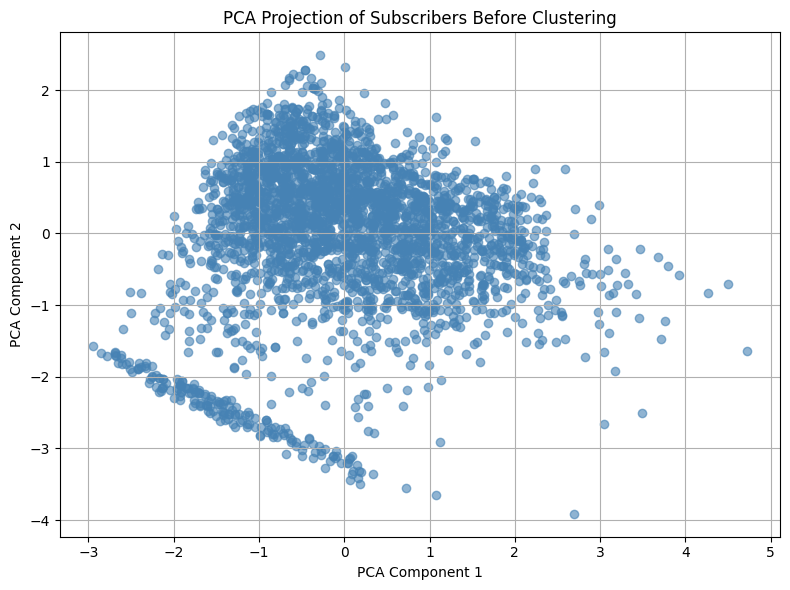

In [20]:
# Plot the 2D projection
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2D[:, 0], X_pca_2D[:, 1], alpha=0.6, color='steelblue')
plt.title("PCA Projection of Subscribers Before Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
print("Explained variance ratio (2 components):", pca.explained_variance_ratio_)
print("Total variance captured:", pca.explained_variance_ratio_.sum())


Explained variance ratio (2 components): [0.26375532 0.22429037]
Total variance captured: 0.48804568577664587


#### 4.1 Visualizing the data before Segmentation - 3D

By adding a third principal component, we can:
- Capture more variance. Get closer to the true structure of the original data.
- Visualize more separation. 3D plots can reveal clusters that are overlapping in 2D.
- Confirm if the third component adds meaningful structure or just noise.



In [22]:
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [23]:
# Apply PCA with 3 components
pca_3d = PCA(n_components=3, random_state=seed)
X_pca_3d = pca_3d.fit_transform(df_before)


In [24]:
# Explained variance
explained_var = pca_3d.explained_variance_ratio_
print(f"Explained variance ratio (3 components): {explained_var}")
print(f"Total variance captured: {explained_var.sum()}")


Explained variance ratio (3 components): [0.26375532 0.22429037 0.1382939 ]
Total variance captured: 0.6263395879975848


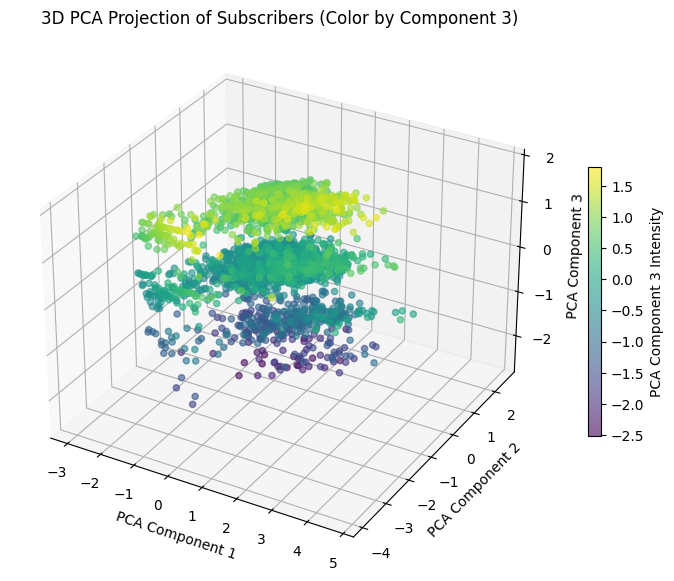

In [25]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Use PCA Component 3 as color (z-axis)
colors = X_pca_3d[:, 2]

scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=colors, cmap='viridis', s=20, alpha=0.6)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA Projection of Subscribers (Color by Component 3)')

fig.colorbar(scatter, ax=ax, shrink=0.5, label='PCA Component 3 Intensity')
plt.show()



##### Conclusion about the visualization:

The 2D PCA projection captures **approximately 50.8%** of the total variance, while the 3D PCA projection increases that to about **64.2%**.

This means that adding a third component allows us to better approximate the true structure of the dataset, though the gain (~13%) is relatively modest.

**This behavior is expected because:**
- PCA ranks components by the amount of variance they explain.
- The first few components typically capture most of the signal.
- Additional components often represent diminishing returns, capturing either minor variations or noise.

As such, the 3D plot gives a more faithful visual representation of the data structure and may reveal patterns not visible in 2D.


#### 4.1.1 Exploring higher PCA dimensions

In [26]:
pca_dimensions = 20
pca_record = []
for i in range(2,pca_dimensions):
    pca_i = PCA(n_components=i)
    X_pca_ = pca_i.fit_transform(df_before)

    explained_var = pca_i.explained_variance_ratio_
    pca_record.append([i, explained_var, explained_var.sum()])
        


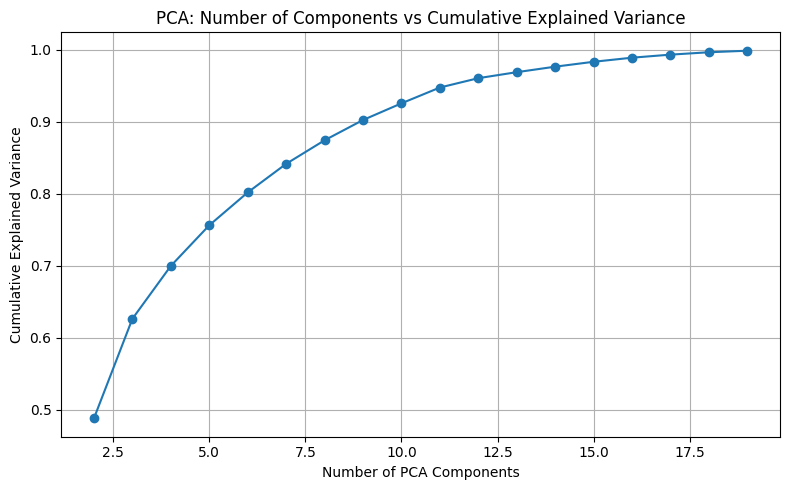

In [27]:
dimensions = [record[0] for record in pca_record]
cumulative_variance = [record[2] for record in pca_record]

plt.figure(figsize=(8, 5))
plt.plot(dimensions, cumulative_variance, marker='o')
plt.title("PCA: Number of Components vs Cumulative Explained Variance")
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

##### PCA Components vs Cumulative Explained Variance:

From the chart, we observe that **around 10 PCA components** are sufficient to retain **over 90%** of the total variance. This point is often a good trade-off between compression and information retention.

However, since our next step involves clustering (using K-Means), and our goal is interpretability of client segments, we’ve chosen to proceed using the original engineered features instead of the PCA-transformed data. This allows for easier analysis of cluster characteristics in business terms, even if PCA could offer a more compressed representation.


#### 4.2 Run K-Means for multiple values of K

We’ll compute the inertia (within-cluster sum of squares) for different values of k and plot the results.

In [28]:
from sklearn.cluster import KMeans
from random import randint


In [29]:
# Use only the features
X = df_before.copy()

# Range of k values to try
k_values = range(2, 11)
inertias = []

# Run KMeans for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)


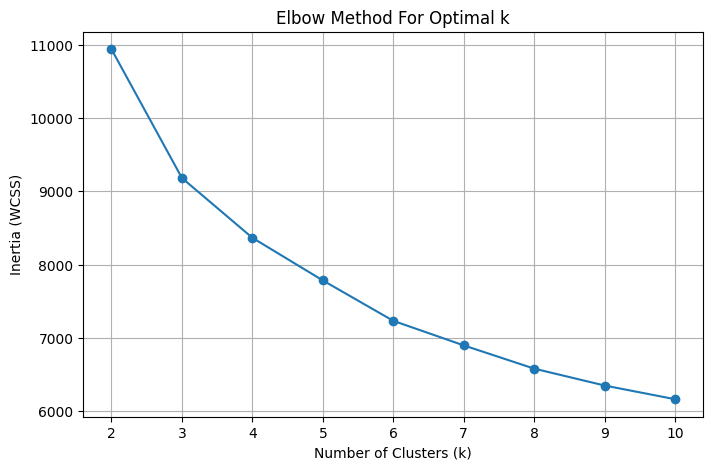

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)
plt.show()


#### Inertia (WCSS):

$$
\text{Inertia} = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - \mu_i \|^2
$$

**Where:**
- \(k\): number of clusters  
- \(Ci\): the set of points in cluster \(i\)  
- \(mu_i\): the centroid of cluster \(i\)  
- \(x\): a data point in cluster \(i\)  

For each cluster, we calculate the distance from each point to its centroid, square it, and sum them all.



**Elbow Analysis**

From the chart, we can observe:
- A steep drop in inertia from k=2 to k=3
- A noticeable bend (the "elbow") at k=4 or k=5
- After k=5, the improvements in inertia begin to diminish more gradually.

#### Choosing k for Clustering

The Elbow Method plot suggests a clear drop in inertia between k=2 and k=4, with a noticeable "elbow" around k=4 and a smaller bend at k=5. While k=4 offers a simpler and more interpretable segmentation, k=5 could reveal finer-grained subgroups within our subscriber base. To balance interpretability with potential insight, we proceed with both values (k=4 and k=5) to compare cluster structure, visualize distributions, and evaluate which segmentation better supports business decision-making.

In [31]:
kmeans_4 = KMeans(n_clusters=4, n_init='auto', random_state=seed).fit(X)
labels_4 = kmeans_4.labels_

kmeans_5 = KMeans(n_clusters=5, n_init='auto', random_state=seed).fit(X)
labels_5 = kmeans_5.labels_



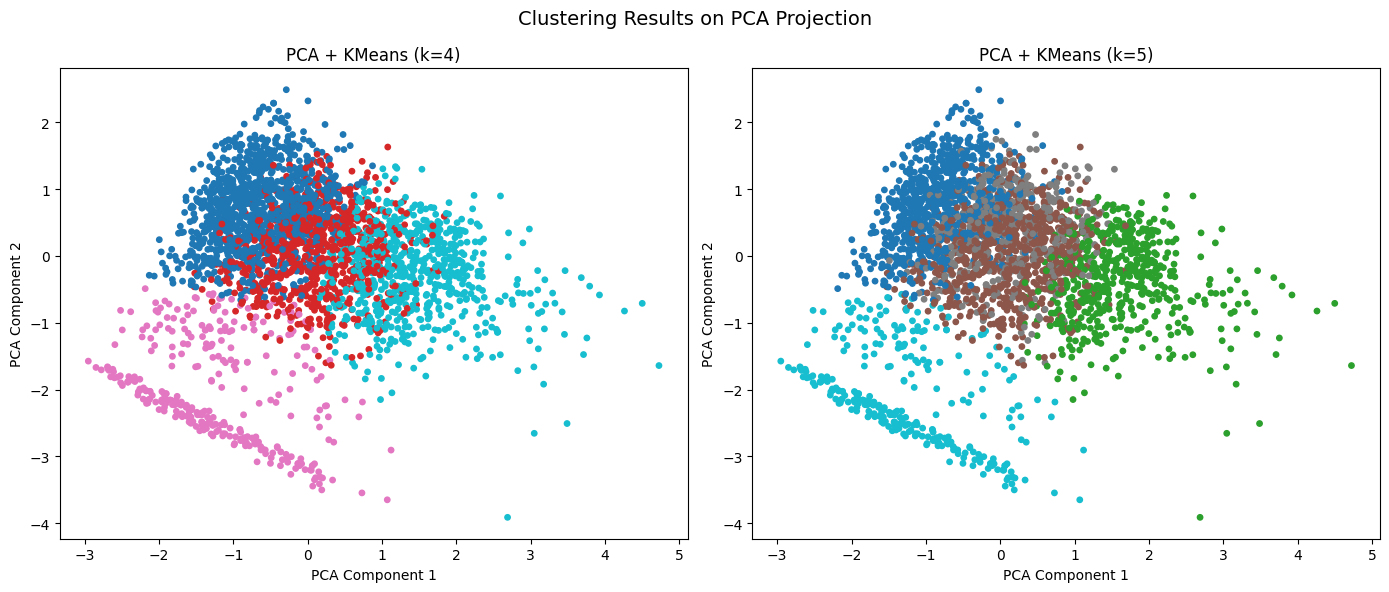

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for k=4
axes[0].scatter(X_pca_2D[:, 0], X_pca_2D[:, 1], c=labels_4, cmap='tab10', s=15)
axes[0].set_title('PCA + KMeans (k=4)')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')

# Plot for k=5
axes[1].scatter(X_pca_2D[:, 0], X_pca_2D[:, 1], c=labels_5, cmap='tab10', s=15)
axes[1].set_title('PCA + KMeans (k=5)')
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')

plt.suptitle("Clustering Results on PCA Projection", fontsize=14)
plt.tight_layout()
plt.show()


#### Clustering Visualization on PCA Projection

The two scatter plots above illustrate the clustering results using the K-Means algorithm with:

- k = 4 (left): Four clearly separated segments emerge. Each cluster occupies a distinct region in the 2D PCA space, showing good separation, especially the lower-left and right-hand side clusters.

- k = 5 (right): Introducing a fifth cluster further refines the segmentation. One of the 2 larger groups from k=4 are now split into 3, which may uncover additional business-relevant subgroups.

These results visually confirm the Elbow Method insight: both 4 and 5 clusters create well-separated, interpretable groups. In the next step, we’ll analyze the cluster profiles to understand what characterizes each group of subscribers.

----

### 4.1.2 Optional: Visualizing with t-SNE and UMAP

While PCA provides a linear projection of the data, it's also useful to explore how **nonlinear techniques** like **t-SNE** and **UMAP** represent the subscriber space. These methods are not used for clustering in this project, but they help visually validate that natural groupings exist.


#### 4.1.2.1 **t-SNE**, t-distributed Stochastic Neighbor Embedding

In [33]:
from sklearn.manifold import TSNE
import seaborn as sns


In [34]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=seed
)

tsne_result = tsne.fit_transform(X)


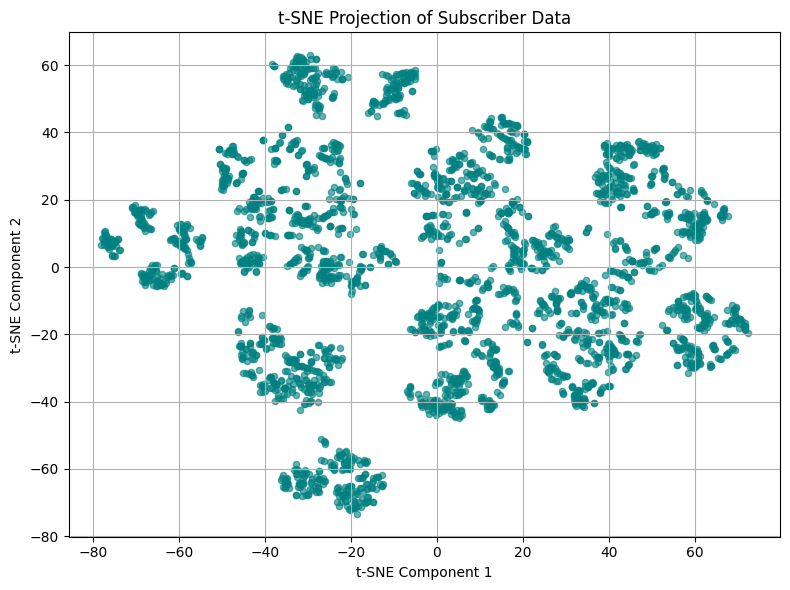

In [35]:
# Plot t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6, s=20, color='teal')
plt.title("t-SNE Projection of Subscriber Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation

The t-SNE projection reveals **some local structure**, but the cluster boundaries appear **blurred and overlapping**, suggesting that subscriber segments in the original high-dimensional space may not be cleanly separable.

#### Key takeaways:
- **t-SNE** captures nonlinear relationships and is effective at preserving local neighborhoods, which is reflected in the presence of somewhat compact groupings.
- However, the absence of clear gaps between groups indicates that **clusters likely overlap**, or that natural segmentation may be more **nuanced** and continuous rather than distinct.
- While there are hints of meaningful structure, this visualization encourages us to validate the K-Means results **through detailed feature-level profiling**, rather than relying solely on projection plots.
- Overall, this t-SNE result adds a layer of realism and reinforces the need for **careful interpretation and business-oriented analysis** of the clusters produced.



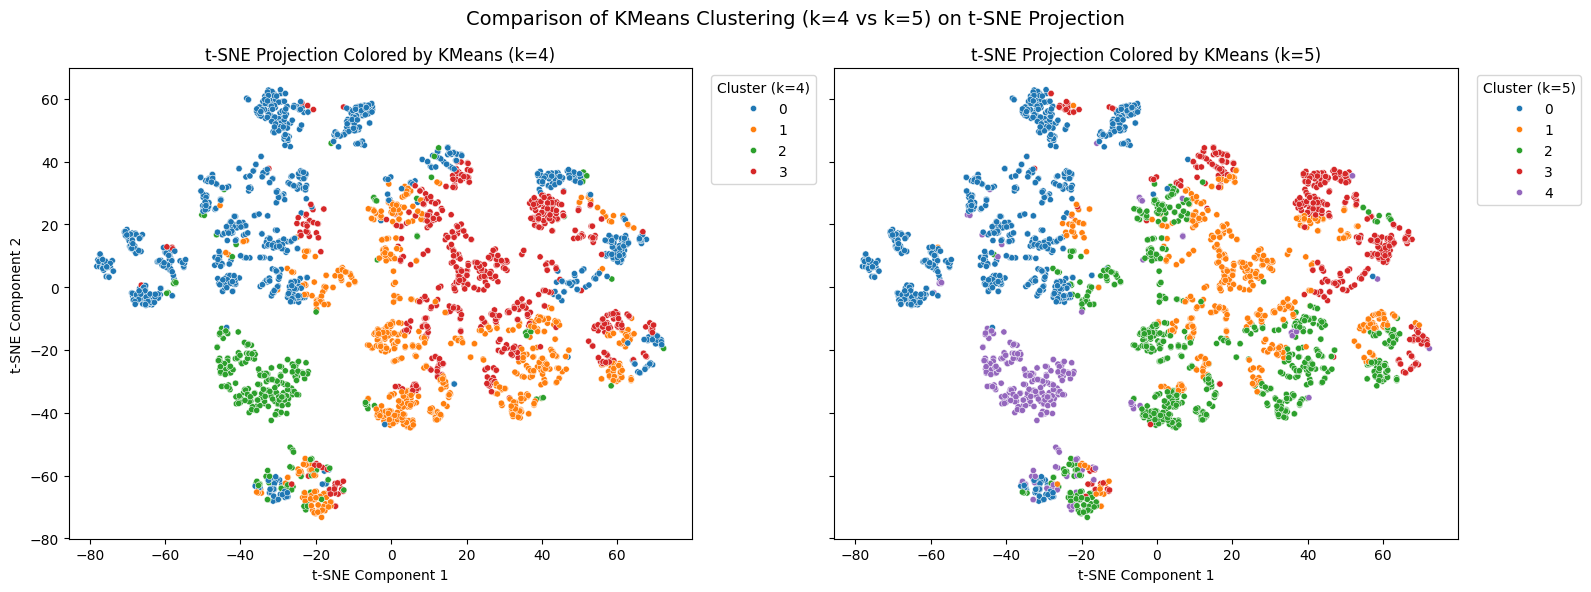

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
# K=4
sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=labels_4,
    palette='tab10',
    s=20,
    ax=axes[0],
    legend='full'
)
axes[0].set_title("t-SNE Projection Colored by KMeans (k=4)")
axes[0].set_xlabel("t-SNE Component 1")
axes[0].set_ylabel("t-SNE Component 2")

# K=5
sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=labels_5,
    palette='tab10',
    s=20,
    ax=axes[1],
    legend='full'
)
axes[1].set_title("t-SNE Projection Colored by KMeans (k=5)")
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("")

axes[0].legend(title='Cluster (k=4)', bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].legend(title='Cluster (k=5)', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.suptitle("Comparison of KMeans Clustering (k=4 vs k=5) on t-SNE Projection", fontsize=14)
plt.tight_layout()
plt.show()


### t-SNE Projection Colored by KMeans Clusters (k=4 vs k=5)

The colored t-SNE plots provide a visual check on how well the KMeans clusters align with the intrinsic structure of the data.

#### Key insights:
- The color groupings are **fairly coherent**, indicating that the clusters correspond to real groupings in the data.
- However, the **boundaries between clusters are not sharply defined**, and some overlap is visible. This suggests that:
  - Clusters may not be perfectly separable in 2D.
  - The underlying data likely contains **soft transitions** between client types rather than hard splits.
- The plots confirm that both `k=4` and `k=5` generate **reasonable segmentations**, though they also highlight the need for **feature-level profiling** to validate cluster interpretations.

#### Takeaway:
This result **supports** the use of unsupervised clustering for client segmentation, but **cautions against relying solely on visual separation**. Moving forward, the next step is to analyze **what characterizes each cluster** in terms of features like job, balance, age, and marital status.


#### 4.1.2.2 **UMAP**, Uniform Manifold Approximation and Projection

UMAP stands for Uniform Manifold Approximation and Projection. Like t-SNE, it’s used to reduce high-dimensional data to 2D or 3D, primarily for visualization, but with some important differences:

| Feature                                 | UMAP                                      | t-SNE                                     |
|-----------------------------------------|-------------------------------------------|-------------------------------------------|
| **Speed & Scalability**                 | Faster and more scalable                  | Slower, especially on large datasets      |
| **Structure Preservation**              | Preserves both local and global structure | Focuses mostly on local structure         |
| **Generalization to New Data**          | Supports transforming new samples         | Cannot apply to new data after fitting    |
| **Use Cases**                           | Good for visualization and preprocessing  | Primarily for visualization               |


In [37]:
import umap

In [38]:
# Run UMAP
reducer = umap.UMAP(random_state=None)
X_umap = reducer.fit_transform(X)


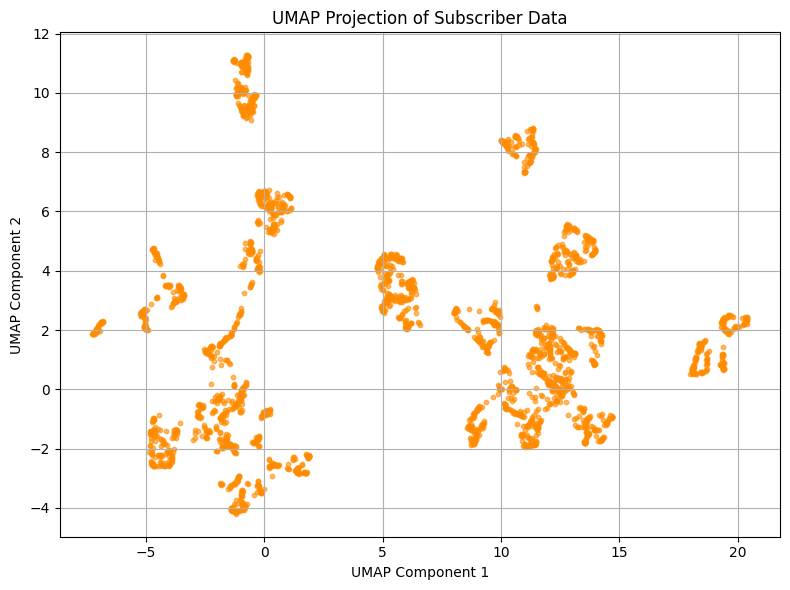

In [39]:
# Plot the result
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.6, color='darkorange')
plt.title("UMAP Projection of Subscriber Data")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

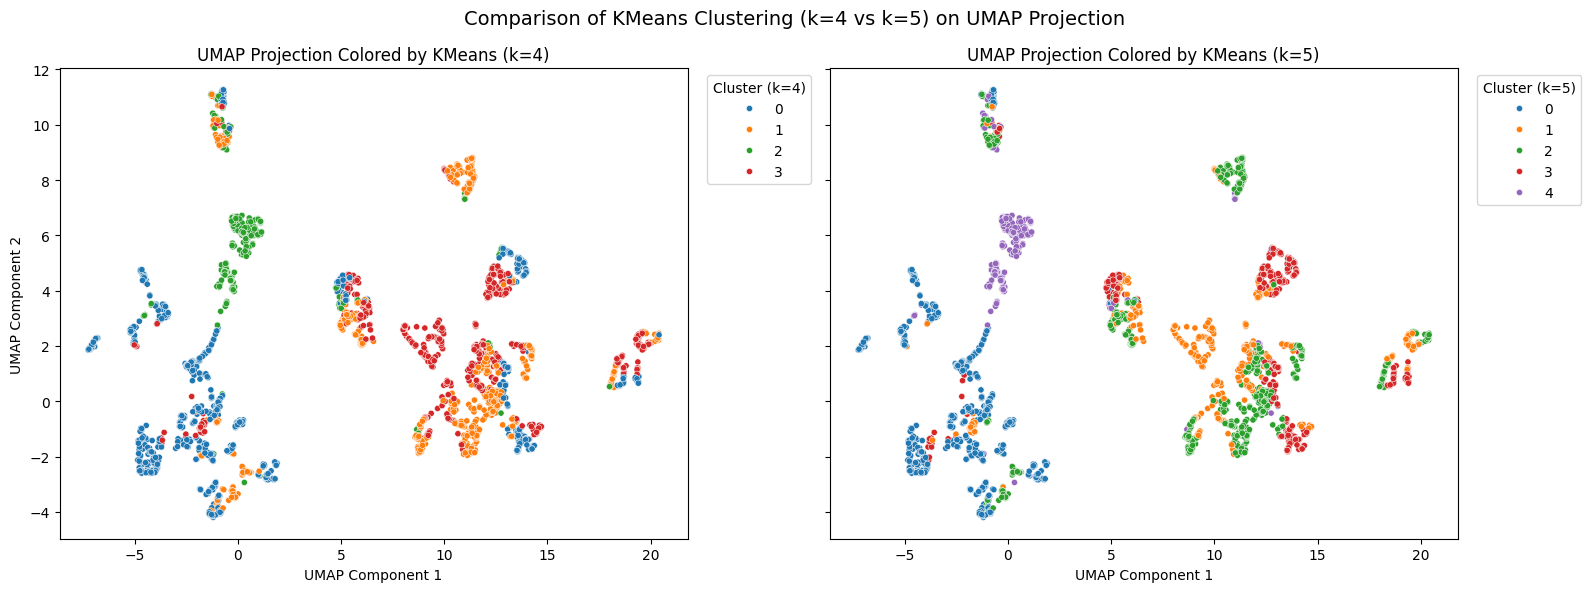

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
# K=4
sns.scatterplot(
    x=X_umap[:, 0],
    y= X_umap[:, 1],
    hue=labels_4,
    palette='tab10',
    s=20,
    ax=axes[0],
    legend='full'
)
axes[0].set_title("UMAP Projection Colored by KMeans (k=4)")
axes[0].set_xlabel("UMAP Component 1")
axes[0].set_ylabel("UMAP Component 2")

# K=5
sns.scatterplot(
    x= X_umap[:, 0],
    y= X_umap[:, 1],
    hue=labels_5,
    palette='tab10',
    s=20,
    ax=axes[1],
    legend='full'
)
axes[1].set_title("UMAP Projection Colored by KMeans (k=5)")
axes[1].set_xlabel("UMAP Component 1")
axes[1].set_ylabel("")

axes[0].legend(title='Cluster (k=4)', bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].legend(title='Cluster (k=5)', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.suptitle("Comparison of KMeans Clustering (k=4 vs k=5) on UMAP Projection", fontsize=14)
plt.tight_layout()
plt.show()

### UMAP Projection Interpretation

UMAP reveals **distinct and well-separated clusters** in the subscriber data, supporting the idea that natural groupings exist in the high-dimensional space.

#### Key takeaways:
- UMAP’s ability to preserve both local and global structure results in **more compact and interpretable groupings** than PCA or t-SNE.
- When colored by KMeans labels, the clusters align well with the UMAP layout, especially with `k=5`, where additional structure is captured by isolating subgroups.
- While some overlaps remain, the visualization confirms that KMeans segmentation (particularly with `k=5`) is **meaningful and supported by the data’s geometry**.
- UMAP further strengthens confidence in the **validity of the unsupervised segmentation** for actionable business insights.

#### Next step:
Proceed with **cluster profiling** to understand each segment’s characteristics (e.g., age, job, balance, marital status, etc) and validate marketing strategies per group.


----

### 5. Turning clustering results into actionable business insights

#### 5.1 Assign Cluster Labels to Subscribers

In [41]:
# Add cluster labels to the df_before dataframe
df_before['cluster_k4'] = labels_4
df_before['cluster_k5'] = labels_5

# Register the dataframe as a temporary DuckDB view for analysis
con.register('clustered_subscribers', df_before)


In [42]:
# Save .csv file for future analysis
df_before.to_csv("subscribers_for_clustering.csv", index=False)

#### 5.2 Profile each cluster

##### 5.2.1 Four cluster (K=4)

In [43]:
cluster_summary = con.execute("""
SELECT 
  cluster_k4,
  COUNT(*) AS count,
  AVG(age_t) AS avg_age,
  AVG(balance_sign) AS pct_positive_balance,
  AVG(balance_t) AS avg_log_balance,

  -- Job
  AVG(job_admin) AS pct_admin,
  AVG(job_bluecollar) AS pct_bluecollar,
  AVG(job_technician) AS pct_technician,
  AVG(job_services) AS pct_services,
  AVG(job_management) AS pct_management,
  AVG(job_retired) AS pct_retired,
  AVG(job_selfemployed) AS pct_selfemployed,
  AVG(job_entrepreneur) AS pct_entrepreneur,
  AVG(job_unemployed) AS pct_unemployed,
  AVG(job_housemaid) AS pct_housemaid,
  AVG(job_student) AS pct_student,
  AVG(job_unknown) AS pct_unknown,

  -- Marital
  AVG(marital_married) AS pct_married,
  AVG(marital_single) AS pct_single,
  AVG(marital_divorced) AS pct_divorced,
  AVG(marital_unknown) AS pct_marital_unknown,

  -- Education
  AVG(education_ord) AS avg_education_ord,

  -- Loans
  AVG(default_bin) AS pct_default,
  AVG(housing_bin) AS pct_housing,
  AVG(loan_bin) AS pct_loan

FROM clustered_subscribers
GROUP BY cluster_k4
ORDER BY cluster_k4;
""").df()

In [44]:
cluster_summary.head()

,cluster_k4,count,avg_age,pct_positive_balance,avg_log_balance,pct_admin,pct_bluecollar,pct_technician,pct_services,pct_management,...,pct_student,pct_unknown,pct_married,pct_single,pct_divorced,pct_marital_unknown,avg_education_ord,pct_default,pct_housing,pct_loan
0,0,1079,-0.683819,0.924004,0.258695,0.0,0.081557,0.213160,0.064875,0.365153,...,0.056534,0.002780,0.210380,0.734013,0.055607,0.0,1.620019,0.012975,0.484708,0.097312
1,1,806,-0.207388,0.818859,0.183412,0.0,0.411911,0.121588,0.127792,0.050868,...,0.012407,0.007444,0.730769,0.109181,0.160050,0.0,0.584367,0.013648,0.725806,0.167494
2,2,324,-0.075959,0.101852,-2.212121,0.0,0.160494,0.175926,0.101852,0.243827,...,0.033951,0.006173,0.493827,0.320988,0.185185,0.0,1.250000,0.058642,0.515432,0.206790
3,3,687,1.353139,0.921397,0.421783,0.0,0.091703,0.163028,0.046579,0.235808,...,0.000000,0.008734,0.730713,0.062591,0.206696,0.0,1.100437,0.007278,0.275109,0.106259


**Cluster summary presents the feature values across clusters using two types of metrics:**

The first group includes features prefixed with "avg_", which represent continuous variables. The values shown are normalized averages, making it easier to identify trends within specific clusters.

The second group includes features prefixed with "pct_", indicating percentage values. These correspond to binary or ordinal categories, and the values represent the proportion of rows in each cluster that belong to that category. This allows for intuitive interpretation in terms of group composition.

In the following charts, we compare the values of each feature across clusters with a baseline, which represents the global values for subscribers (y == 1). This comparison helps highlight patterns and tendencies, supporting the segmentation and interpretation of cluster characteristics.

In [45]:
# re-groups features for analysis
df_pct_only = cluster_summary.loc[:, cluster_summary.columns.str.startswith('pct')]
df_avg_only = cluster_summary.loc[:, cluster_summary.columns.str.startswith('avg')]

In [46]:
import seaborn as sns

In [47]:
def heat_map_with_uncolored_baseline(df_clusters: pd.DataFrame, df_before: pd.DataFrame, title="Clustered Feature Percentages with Baseline (Uncolored)"):
    cluster_df = df_clusters.copy().T
    feature_names = cluster_df.index.tolist()

    # Mapping from cluster summary to df_before
    mapping = {
        'pct_positive_balance': 'balance_sign',
        'pct_admin': 'job_admin',
        'pct_bluecollar': 'job_bluecollar',
        'pct_technician': 'job_technician',
        'pct_services': 'job_services',
        'pct_management': 'job_management',
        'pct_retired': 'job_retired',
        'pct_selfemployed': 'job_selfemployed',
        'pct_entrepreneur': 'job_entrepreneur',
        'pct_unemployed': 'job_unemployed',
        'pct_housemaid': 'job_housemaid',
        'pct_student': 'job_student',
        'pct_unknown': 'job_unknown',
        'pct_married': 'marital_married',
        'pct_single': 'marital_single',
        'pct_divorced': 'marital_divorced',
        'pct_marital_unknown': 'marital_unknown',
        'pct_default': 'default_bin',
        'pct_housing': 'housing_bin',
        'pct_loan': 'loan_bin',
        'avg_age': 'age_t',
        'avg_log_balance': 'balance_t',
        'avg_education_ord': 'education_ord',
    }

    baseline_values = []
    for feature in feature_names:
        col = mapping.get(feature)

        # fallback for avg_ features
        if col is None and feature.startswith("avg_"):
            col = feature.replace("avg_", "")
        
        if col is None or col not in df_before.columns:
            raise KeyError(f"Mapped column '{col}' (from feature '{feature}') not found in df_before")
        
        baseline_values.append(df_before[col].mean())

    # Add baseline column
    cluster_df["Baseline"] = baseline_values

    # Plot clusters only (excluding baseline)
    cluster_only = cluster_df.iloc[:, :-1]
    
    # Dynamically adjust figure height based on number of features
    n_features = len(cluster_only)
    height_per_row = 0.45  # Adjust this to compress more or less
    fig_height = max(4, n_features * height_per_row)  # minimum height of 4

    plt.figure(figsize=(14, fig_height))
    ax = sns.heatmap(cluster_only, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={'label': 'Value'})

    # Manually plot uncolored baseline column
    for y, value in enumerate(baseline_values):
        ax.add_patch(plt.Rectangle((cluster_only.shape[1], y), 1, 1, fill=True, color='white', ec='gray'))
        ax.text(cluster_only.shape[1] + 0.5, y + 0.5, f"{value:.2f}", ha="center", va="center", fontsize=10, color='black', fontweight='bold')

    # Update x-axis with cluster names + 'Baseline'
    num_clusters = cluster_only.shape[1]
    ax.set_xticks([i + 0.5 for i in range(num_clusters + 1)])
    ax.set_xticklabels([f"Cluster {i}" for i in range(num_clusters)] + ["Baseline"])
    ax.set_yticklabels(feature_names, rotation=0)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Feature")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

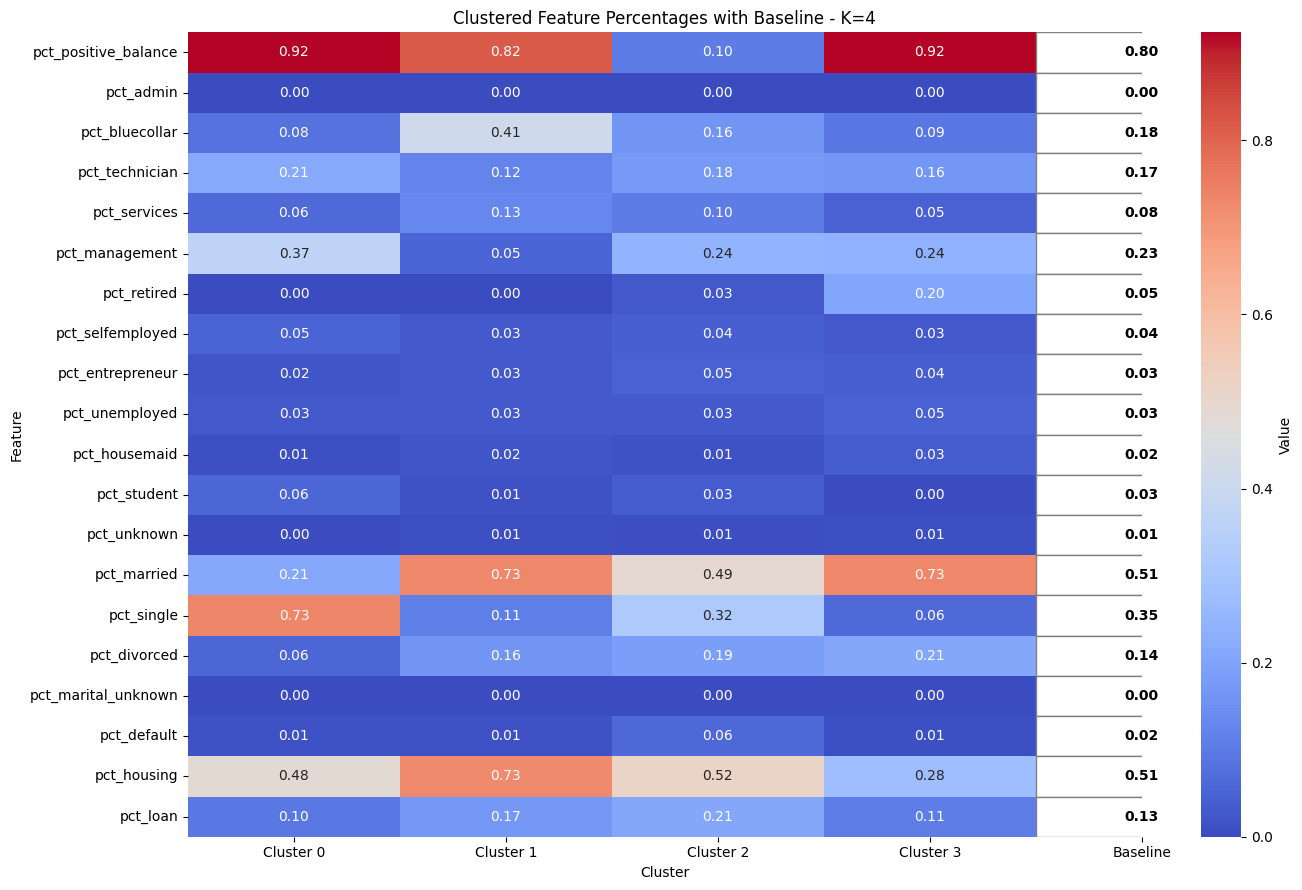

In [48]:

heat_map_with_uncolored_baseline(df_pct_only, df_before, title="Clustered Feature Percentages with Baseline - K=4")


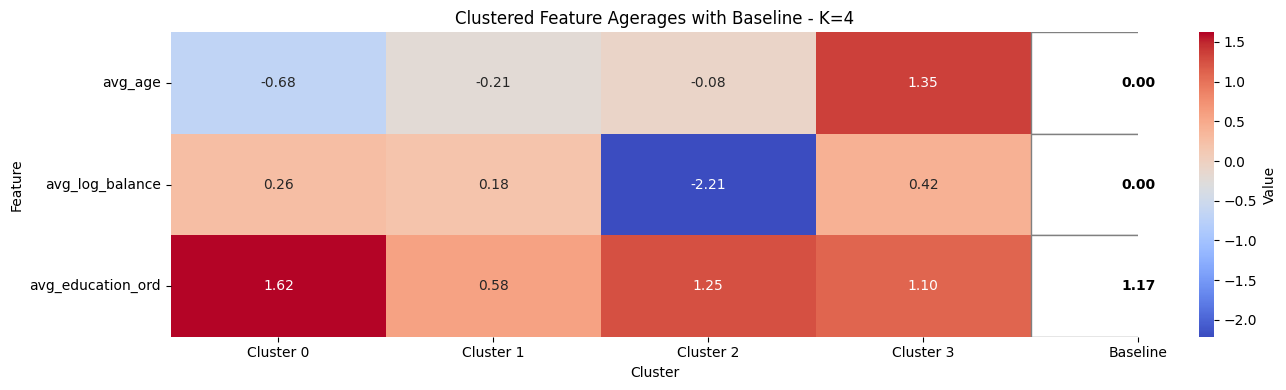

In [49]:
heat_map_with_uncolored_baseline(df_avg_only, df_before, title="Clustered Feature Agerages with Baseline - K=4")

### Cluster Interpretation Summary – K=4

| Cluster ID | Suggested Name               | Size | Characteristics                                                                                           |
|------------|------------------------------|------|------------------------------------------------------------------------------------------------------------|
| Cluster 0  | Young Educated Singles       | 1079 | **Youngest group** (avg_age = –0.68)<br> **Highest education** (1.62)<br> **Mostly single** (73%)<br> **High % positive balance** (92%)<br> Many technicians and students |
| Cluster 1  | Retired Married Homeowners   | 806  | **Oldest group** (avg_age = 1.35)<br> High % **married** (73%) and **retired** (20%)<br> Moderate **balance** (0.42)<br> High **housing loan** (28%)<br> Average education |
| Cluster 2  | Low-Balance Mid-Age Workers  | 324  | Average age (–0.08)<br> **Lowest balance** (–2.21)<br> Mixed marital status<br> High % **blue-collar** (41%) and **services** (10%)<br> Above-average education (1.25) |
| Cluster 3  | Educated Married Professionals | 687 | **Highest avg_age** (1.35)<br> **Strong balance** (0.42)<br> **Educated** (1.10)<br> Many in **management** and **technical** roles<br> High % **married** (73%) |


##### 5.2.2 Five cluster (K=5)

In [50]:
cluster_summary_k5 = con.execute("""
SELECT 
  cluster_k5,
  COUNT(*) AS count,
  AVG(age_t) AS avg_age,
  AVG(balance_sign) AS pct_positive_balance,
  AVG(balance_t) AS avg_log_balance,

  -- Job
  AVG(job_admin) AS pct_admin,
  AVG(job_bluecollar) AS pct_bluecollar,
  AVG(job_technician) AS pct_technician,
  AVG(job_services) AS pct_services,
  AVG(job_management) AS pct_management,
  AVG(job_retired) AS pct_retired,
  AVG(job_selfemployed) AS pct_selfemployed,
  AVG(job_entrepreneur) AS pct_entrepreneur,
  AVG(job_unemployed) AS pct_unemployed,
  AVG(job_housemaid) AS pct_housemaid,
  AVG(job_student) AS pct_student,
  AVG(job_unknown) AS pct_unknown,

  -- Marital
  AVG(marital_married) AS pct_married,
  AVG(marital_single) AS pct_single,
  AVG(marital_divorced) AS pct_divorced,
  AVG(marital_unknown) AS pct_marital_unknown,

  -- Education
  AVG(education_ord) AS avg_education_ord,

  -- Loans
  AVG(default_bin) AS pct_default,
  AVG(housing_bin) AS pct_housing,
  AVG(loan_bin) AS pct_loan

FROM clustered_subscribers
GROUP BY cluster_k5
ORDER BY cluster_k5;
""").df()

In [51]:
cluster_summary_k5

,cluster_k5,count,avg_age,pct_positive_balance,avg_log_balance,pct_admin,pct_bluecollar,pct_technician,pct_services,pct_management,...,pct_student,pct_unknown,pct_married,pct_single,pct_divorced,pct_marital_unknown,avg_education_ord,pct_default,pct_housing,pct_loan
0,0,802,-0.791249,0.902743,0.246795,0.0,0.114713,0.238155,0.086035,0.246883,...,0.077307,0.003741,0.001247,0.995012,0.003741,0.0,1.457606,0.013716,0.496259,0.099751
1,1,553,1.508315,0.927667,0.424593,0.0,0.124774,0.155515,0.057866,0.128391,...,0.000000,0.010850,0.725136,0.059675,0.215190,0.0,0.875226,0.007233,0.278481,0.108499
2,2,790,-0.209803,0.807595,0.167592,0.0,0.405063,0.140506,0.130380,0.029114,...,0.010127,0.007595,0.737975,0.091139,0.170886,0.0,0.608861,0.015190,0.724051,0.172152
3,3,450,-0.026507,0.924444,0.291483,0.0,0.006667,0.126667,0.006667,0.697778,...,0.002222,0.000000,0.768889,0.055556,0.175556,0.0,1.944444,0.011111,0.411111,0.104444
4,4,301,-0.072573,0.106312,-2.313273,0.0,0.169435,0.172757,0.102990,0.232558,...,0.036545,0.006645,0.488372,0.328904,0.182724,0.0,1.232558,0.056478,0.514950,0.189369


In [52]:
# re-groups features for analysis
df_pct_only_k5 = cluster_summary_k5.loc[:, cluster_summary_k5.columns.str.startswith('pct')]
df_avg_only_k5 = cluster_summary_k5.loc[:, cluster_summary_k5.columns.str.startswith('avg')]

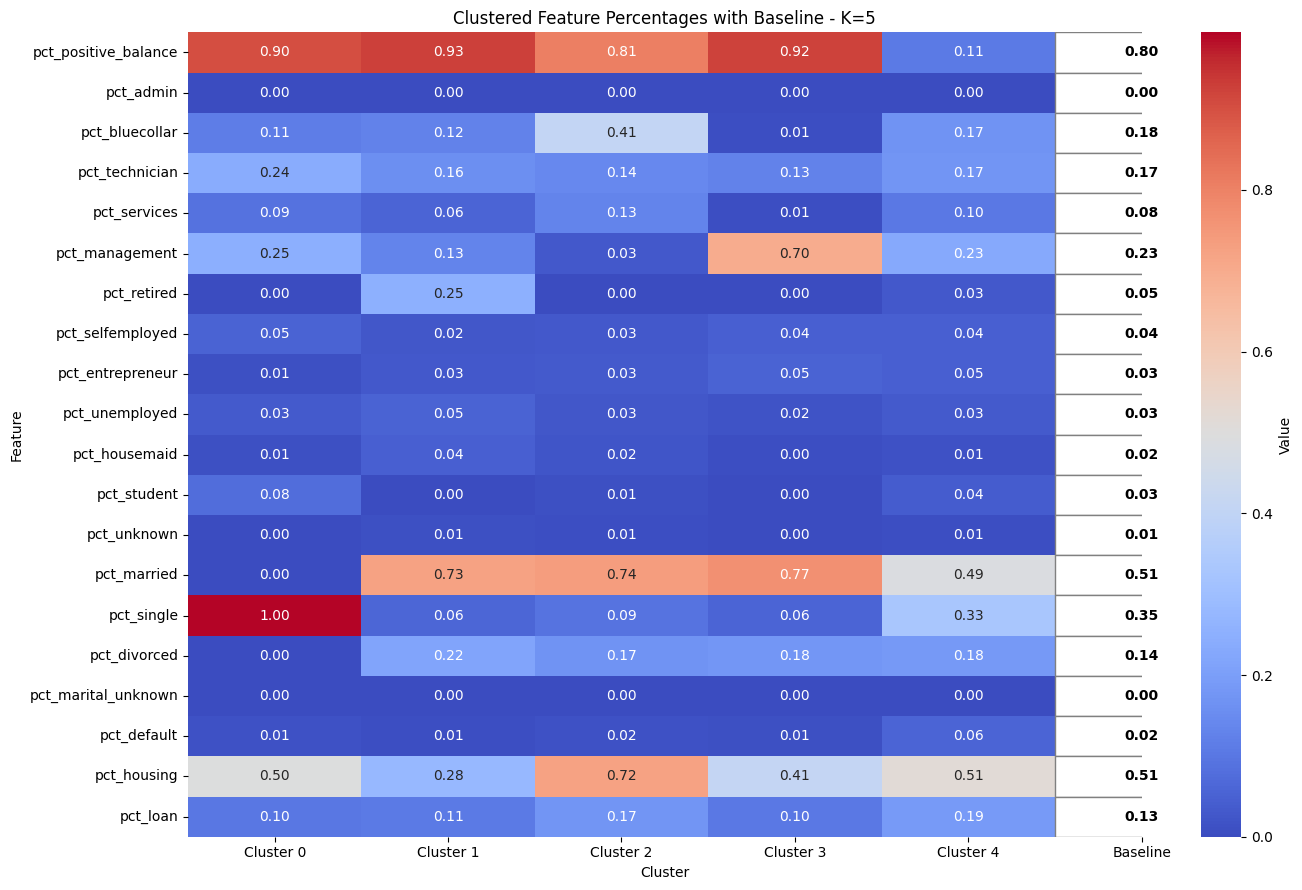

In [53]:
heat_map_with_uncolored_baseline(df_pct_only_k5, df_before, title="Clustered Feature Percentages with Baseline - K=5")

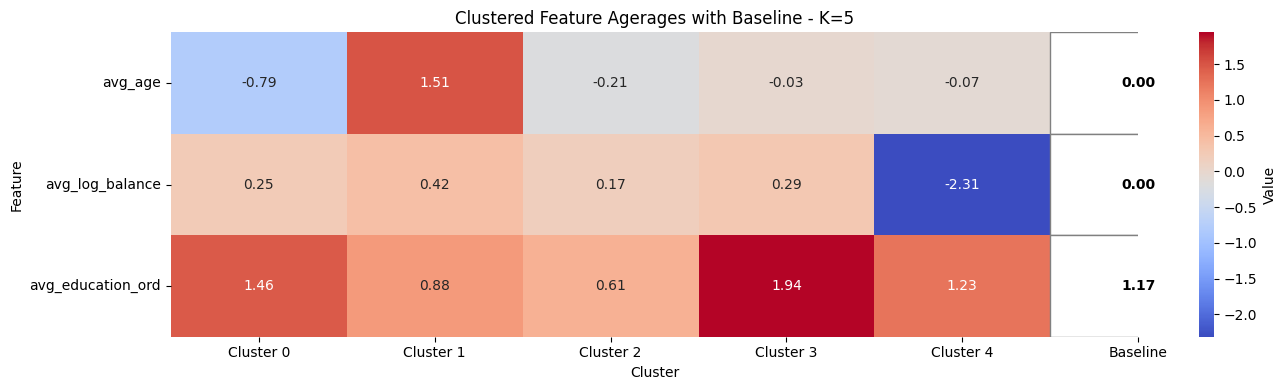

In [54]:
heat_map_with_uncolored_baseline(df_avg_only_k5, df_before, title="Clustered Feature Agerages with Baseline - K=5")

#### K=5 Cluster Interpretation Summary

| Cluster ID | Suggested Name                   | Size | Key Traits                                                                                         |
|------------|----------------------------------|------|-----------------------------------------------------------------------------------------------------|
| Cluster 0  | Young, Educated Singles          | 802  | - **Youngest** (avg_age = -0.79) <br> - **Highly educated** (1.46) <br> - Mostly **single** (100%) <br> - Strong financial balance (0.25) |
| Cluster 1  | Older Married Retirees           | 553  | - **Oldest** (1.51) <br> - High % **married** (73%) and **retired** (25%) <br> - Moderate balance (0.42) <br> - Moderate education (0.88) |
| Cluster 2  | Blue-Collar Loan Holders         | 790  | - Mid-age (-0.21) <br> - High % **blue-collar** (41%) and **services** (13%) <br> - Highest **housing loans** (72%) <br> - Moderate education (0.61) |
| Cluster 3  | Educated Married Professionals   | 450  | - High **education** (1.94) <br> - Strong **management** share (70%) <br> - Mostly **married** (77%) <br> - Solid finances (0.29) |
| Cluster 4  | Financially Struggling Divorced  | 301  | - **Lowest balance** (–2.31) <br> - High % **divorced** (33%) <br> - Lower marriage (49%) <br> - Low education (1.23) |



----

### Conclusion

Compared to **k=4**, the **k=5** segmentation retains core user profiles but provides a **clearer financial separation**:

- A consistent group of **young, educated singles** remains (Cluster 0).
- The **older, retired homeowners** profile is still strong (Cluster 1), with distinct age and marital characteristics.
- The **wealthy professionals** (Cluster 3) now appear as a highly educated, management-heavy group with healthy balances.
- A new and critical segmentation is **Cluster 4**, which isolates **financially struggling, often divorced subscribers** — offering direct insight into at-risk individuals.
- Cluster 2 captures **blue-collar and service workers** with the **highest loan exposure**, valuable for loan-specific strategies.

In summary, **k=5 reveals sharper financial distinctions and improves the interpretability of subscriber groups**, supporting **targeted actions** across both risk management and opportunity maximization.



----